In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Data Exploration
General Notes:
- The files that do not follow the naming conventions have missing metadata (Root Attributes in h5)

In [ ]:
import re

import h5py
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

from roar import ALL_VEHICLES, DATA_DIR, EXTRAS_DIR, VEHICLE_CLEAN_NAMES

In [ ]:
# Some data cleaning for better usability
all_channel_names = pl.read_csv(EXTRAS_DIR / "all_measurement_channels name.csv")
all_channel_names = all_channel_names.with_columns(
    pl.col("vehicle")
    .str.replace(" ", "")
    .str.split(",")
    .replace(VEHICLE_CLEAN_NAMES)
    .replace({tuple(["alle"]): ALL_VEHICLES}),
    pl.col("relevance").cast(pl.Categorical),
)
all_channel_names

In [ ]:
# Speed/measurement type information
speed_info = pl.read_csv(EXTRAS_DIR / "speed.csv")
speed_info

In [ ]:
# Track information
tracks = pl.read_csv(EXTRAS_DIR / "tracks.csv")
tracks

In [ ]:
# tyre information
tyres = pl.read_csv(EXTRAS_DIR / "tyres.csv")
tyres

## h5 files

In [ ]:
# List all h5 files in the data directory
h5_files = [p for p in DATA_DIR.rglob("*.h5") if "HDF_Test_Export" not in str(p)]

files_df = pl.DataFrame(
    {
        "file_path": [str(f) for f in h5_files],  # Convert to string for polars compatibility
        "stem": [f.stem for f in h5_files],
        "track_ID": [int(file.parent.parent.parent.name) for file in h5_files],
        "tyre_ID": [int(re.search(r"Tyre\s*(\d+)", s.parent.name).group(1)) for s in h5_files],  # type: ignore
        "vehicle": [file.parent.parent.name for file in h5_files],
        "conventional_naming": [f.stem.startswith("track") for f in h5_files],
    }
)
files_df

In [ ]:
# Extract measurement and date
files_df = files_df.with_columns(
    pl.when(pl.col("conventional_naming"))
    .then(pl.col("stem").str.extract(r"(meas\d+)", 1))
    .otherwise(
        pl.when(pl.col("stem").str.starts_with("b"))
        .then(
            pl.concat_str(
                [
                    pl.col("stem").str.extract(r"^(b\d+)", 1),
                    pl.lit("_vr"),
                    pl.col("stem").str.extract(r"vr(\d+)", 1),
                ]
            )
        )
        .otherwise(
            pl.concat_str(
                [
                    pl.lit("vr"),
                    pl.col("stem").str.extract(r"vr(\d+)", 1),
                ]
            )
        )
    )
    .alias("masurement"),
    # extract timestamp (as string)
    pl.col("stem")
    .str.extract(r"(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})", 1)
    .str.strptime(pl.Datetime, "%Y-%m-%d_%H-%M-%S")
    .alias("date"),
)
files_df

In [9]:
import numpy as np


def extract_h5_variables(filename):
    """Extract variable information from an HDF5 file."""
    variables = []

    with h5py.File(filename, "r") as f:

        def collect_datasets(name, obj):
            if isinstance(obj, h5py.Dataset):
                # Get sample_rate from attributes if it exists
                sample_rate = obj.attrs.get("sample_rate", None)
                if isinstance(sample_rate, np.ndarray):
                    sample_rate = sample_rate.astype(np.int32).item()
                else:
                    sample_rate = None

                variables.append(
                    {
                        "variable_name": name,
                        "variable_shape": list(obj.shape),
                        "sample_rate": sample_rate,
                    }
                )

        f.visititems(collect_datasets)

    return variables


def expand_files_with_variables_efficient(files_df, filename_col="file_path"):
    """More efficient version using Polars operations."""
    struct_schema = pl.Struct(
        {
            "variable_name": pl.Utf8,
            "variable_shape": pl.List(pl.Int64),
            "sample_rate": pl.Int32,
        }
    )

    # Apply extraction to each file and explode
    expanded_df = (
        files_df.with_columns(
            pl.col(filename_col)
            .map_elements(extract_h5_variables, return_dtype=pl.List(struct_schema))
            .alias("variables")
        )
        .explode("variables")
        .unnest("variables")
    )

    return expanded_df


files_df_expanded = expand_files_with_variables_efficient(files_df)
files_df_expanded

file_path,stem,track_ID,tyre_ID,vehicle,conventional_naming,masurement,date,variable_name,variable_shape,sample_rate
str,str,i64,i64,str,bool,str,datetime[μs],str,list[i64],i32
"""/Users/moritzfeik/Developer/RO…","""b35_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4""",false,"""b35_vr50""",2025-07-11 09:55:07,"""Antrieb""","[1, 250200]",36000
"""/Users/moritzfeik/Developer/RO…","""b35_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4""",false,"""b35_vr50""",2025-07-11 09:55:07,"""BCM1_Aussen_Temp""","[1, 6950]",1000
"""/Users/moritzfeik/Developer/RO…","""b35_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4""",false,"""b35_vr50""",2025-07-11 09:55:07,"""Cnt_CAN_Sig_0_""","[1, 6950]",1000
"""/Users/moritzfeik/Developer/RO…","""b35_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4""",false,"""b35_vr50""",2025-07-11 09:55:07,"""Cnt_CAN_Sig_12_""","[1, 6950]",1000
"""/Users/moritzfeik/Developer/RO…","""b35_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4""",false,"""b35_vr50""",2025-07-11 09:55:07,"""Cnt_CAN_Sig_16_""","[1, 6950]",1000
…,…,…,…,…,…,…,…,…,…,…
"""/Users/moritzfeik/Developer/RO…","""track150_Taycan_tyre10_meas1_2…",150,10,"""03 Porsche Taycan""",true,"""meas1""",2025-09-23 17:21:41,"""v_east_CAN_Sig_""","[1, 6650]",1000
"""/Users/moritzfeik/Developer/RO…","""track150_Taycan_tyre10_meas1_2…",150,10,"""03 Porsche Taycan""",true,"""meas1""",2025-09-23 17:21:41,"""v_north_CAN_Sig""","[1, 6650]",1000
"""/Users/moritzfeik/Developer/RO…","""track150_Taycan_tyre10_meas1_2…",150,10,"""03 Porsche Taycan""",true,"""meas1""",2025-09-23 17:21:41,"""v_up_CAN_Sig_11""","[1, 6650]",1000


In [22]:
# Set style for clean, modern plots
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["figure.dpi"] = 100

# Fixed color palette for vehicles (professional, distinct colors)
VEHICLE_COLORS = {
    "01 VW ID4": "#3498db",  # Blue
    "02 Audi Q8": "#e74c3c",  # Red
    "03 Porsche Taycan": "#2ecc71",  # Green
    "04 VW eGolf": "#9b59b6",  # Purple
}

# Fixed color palette for tyres (warm to cool gradient, easily distinguishable)
TYRE_COLORS = {
    1: "#e63946",  # Red
    3: "#f4a261",  # Orange
    6: "#e9c46a",  # Yellow
    10: "#2a9d8f",  # Teal
    12: "#264653",  # Dark Blue
    13: "#7209b7",  # Purple
}


def plot_experiments_by_tyre(df):
    """Pie chart of experiments by Tyre ID"""
    pdf = (
        df.group_by("tyre_ID")
        .agg(pl.col("file_path").n_unique().alias("experiments"))
        .sort("tyre_ID")
        .to_pandas()
    )

    fig, ax = plt.subplots(figsize=(8, 6))
    colors = [TYRE_COLORS.get(t, "#95a5a6") for t in pdf["tyre_ID"]]

    ax.pie(
        pdf["experiments"],
        labels=[f"Tyre {t}" for t in pdf["tyre_ID"]],
        autopct="%1.1f%%",
        colors=colors,
        startangle=90,
        explode=[0.02] * len(pdf),
        shadow=False,
        wedgeprops={"edgecolor": "white", "linewidth": 2},
    )

    ax.set_title("Experiments by Tyre ID", fontsize=14, pad=15)
    plt.tight_layout()
    return fig


def plot_experiments_by_vehicle(df):
    """Pie chart of experiments by Vehicle"""
    pdf = (
        df.group_by("vehicle")
        .agg(pl.col("file_path").n_unique().alias("experiments"))
        .sort("vehicle")
        .to_pandas()
    )

    fig, ax = plt.subplots(figsize=(8, 6))
    colors = [VEHICLE_COLORS.get(v, "#95a5a6") for v in pdf["vehicle"]]

    # Clean vehicle names for display
    clean_labels = [v.split(" ", 1)[1] if " " in v else v for v in pdf["vehicle"]]

    ax.pie(
        pdf["experiments"],
        labels=clean_labels,
        autopct="%1.1f%%",
        colors=colors,
        startangle=90,
        explode=[0.02] * len(pdf),
        shadow=False,
        wedgeprops={"edgecolor": "white", "linewidth": 2},
    )

    ax.set_title("Experiments by Vehicle", fontsize=14, pad=15)
    plt.tight_layout()
    return fig


def plot_tyre_track_heatmap(df):
    """Heatmap of Tyre × Track experiments"""
    pdf = (
        df.group_by(["tyre_ID", "track_ID"])
        .agg(pl.col("file_path").n_unique().alias("experiments"))
        .to_pandas()
    )

    pivot_data = pdf.pivot(index="tyre_ID", columns="track_ID", values="experiments")

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        pivot_data,
        annot=True,
        fmt=".0f",
        cmap="flare_r",
        ax=ax,
        cbar_kws={"label": "Experiments", "shrink": 0.8},
        annot_kws={"fontsize": 11, "fontweight": "bold"},
        linewidths=0.5,
        linecolor="white",
    )
    ax.set_xlabel("Track ID", fontsize=12)
    ax.set_ylabel("Tyre ID", fontsize=12)
    ax.set_title("Experiments: Tyre × Track", fontsize=14, pad=15)
    plt.tight_layout()
    return fig


def plot_experiments_by_track_bar(df):
    """Stacked bar chart of experiments by Track, colored by Tyre ID"""
    pdf = (
        df.group_by(["track_ID", "tyre_ID"])
        .agg(pl.col("file_path").n_unique().alias("experiments"))
        .to_pandas()
    )

    pivot_data = pdf.pivot(index="track_ID", columns="tyre_ID", values="experiments").fillna(0)

    # Sort by total experiments
    pivot_data["total"] = pivot_data.sum(axis=1)
    pivot_data = pivot_data.sort_values("total", ascending=False).drop(columns="total")

    fig, ax = plt.subplots(figsize=(9, 6))

    # Get colors for each tyre column
    colors = [TYRE_COLORS.get(int(col), "#95a5a6") for col in pivot_data.columns]

    pivot_data.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=colors,
        width=0.75,
        edgecolor="white",
        linewidth=0.5,
    )

    ax.set_xlabel("Track ID", fontsize=12)
    ax.set_ylabel("Number of Experiments", fontsize=12)
    ax.set_title("Experiments by Track (stacked by Tyre)", fontsize=14, pad=15)
    ax.legend(
        title="Tyre ID",
        loc="upper right",
        fontsize=9,
        title_fontsize=10,
        framealpha=0.9,
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.xticks(rotation=0)
    plt.tight_layout()
    return fig


def plot_experiments_by_tyre_bar(df):
    """Bar chart of experiments by Tyre, colored by vehicle type"""
    pdf = (
        df.group_by(["tyre_ID", "vehicle"])
        .agg(pl.col("file_path").n_unique().alias("experiments"))
        .sort("experiments", descending=True)
        .to_pandas()
    )

    fig, ax = plt.subplots(figsize=(9, 6))

    sns.barplot(
        data=pdf,
        x="tyre_ID",
        y="experiments",
        hue="vehicle",
        palette=VEHICLE_COLORS,
        dodge=False,
        ax=ax,
        edgecolor="white",
        linewidth=1,
    )

    ax.set_xlabel("Tyre ID", fontsize=12)
    ax.set_ylabel("Number of Experiments", fontsize=12)
    ax.set_title("Experiments by Tyre (colored by Vehicle)", fontsize=14, pad=15)

    # Clean legend labels
    handles, labels = ax.get_legend_handles_labels()
    clean_labels = [lab.split(" ", 1)[1] if " " in lab else lab for lab in labels]
    ax.legend(
        handles,
        clean_labels,
        title="Vehicle",
        loc="upper right",
        fontsize=9,
        title_fontsize=10,
        framealpha=0.9,
    )

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.xticks(rotation=0)
    plt.tight_layout()
    return fig


def print_dataset_summary(df):
    """Print dataset summary statistics"""
    print("=" * 45)
    print("           DATASET SUMMARY")
    print("=" * 45)
    print(f"  Total Rows:          {len(df):,}")
    print(f"  Unique Variables:    {df['variable_name'].n_unique()}")
    print(f"  Unique Experiments:  {df['file_path'].n_unique()}")
    print()
    print(f"  Vehicles:  {df['vehicle'].n_unique()}")
    print(f"  Tyres:     {df['tyre_ID'].n_unique()}")
    print(f"  Tracks:    {df['track_ID'].n_unique()}")
    print()
    print("  Sample Rates:")
    print(f"    Min:   {df['sample_rate'].min()} Hz")
    print(f"    Max:   {df['sample_rate'].max()} Hz")
    print(f"    Mean:  {df['sample_rate'].mean():.1f} Hz")
    print()
    print("  Date Range:")
    print(f"    From:  {df['date'].min()}")
    print(f"    To:    {df['date'].max()}")
    print("=" * 45)


def plot_variable_shape_dimensions(df):
    """Plot distribution of variable dimensions"""
    pdf = df.with_columns(pl.col("variable_shape").list.len().alias("n_dims")).to_pandas()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Number of dimensions per variable
    sns.countplot(
        data=pdf,
        x="n_dims",
        ax=ax1,
        color="#3498db",
        edgecolor="white",
        linewidth=1,
    )
    ax1.set_xlabel("Number of Dimensions", fontsize=12)
    ax1.set_ylabel("Count", fontsize=12)
    ax1.set_title("Distribution of Variable Dimensions", fontsize=13, pad=10)
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)

    # Shape size distribution (log scale)
    sizes_df = (
        df.with_columns(
            pl.col("variable_shape").list.eval(pl.element().product()).list.first().alias("size")
        )
        .filter(pl.col("size").is_not_null())
        .to_pandas()
    )
    sizes_df["log_size"] = np.log10(sizes_df["size"])

    sns.histplot(
        data=sizes_df,
        x="log_size",
        bins=30,
        ax=ax2,
        color="#e74c3c",
        edgecolor="white",
        linewidth=0.5,
    )
    ax2.set_xlabel(r"$\log_{10}$(Total Elements)", fontsize=12)
    ax2.set_ylabel("Frequency", fontsize=12)
    ax2.set_title("Distribution of Variable Sizes", fontsize=13, pad=10)
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)

    plt.tight_layout()
    return fig


def plot_sample_rate_by_variable(df):
    """Plot sample rates for different variables"""
    pdf = (
        df.group_by(["variable_name", "sample_rate"])
        .agg(pl.len().alias("count"))
        .filter(pl.col("sample_rate").is_not_null())
        .to_pandas()
    )

    fig, ax = plt.subplots(figsize=(11, 6))

    sns.scatterplot(
        data=pdf,
        x="sample_rate",
        y="variable_name",
        size="count",
        sizes=(50, 400),
        alpha=0.7,
        ax=ax,
        color="#2a9d8f",
        legend=False,
    )

    ax.set_xlabel("Sample Rate (Hz)", fontsize=12)
    ax.set_ylabel("Variable Name", fontsize=12)
    ax.set_title("Sample Rates by Variable", fontsize=14, pad=15)
    ax.grid(True, alpha=0.3, axis="x")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()
    return fig

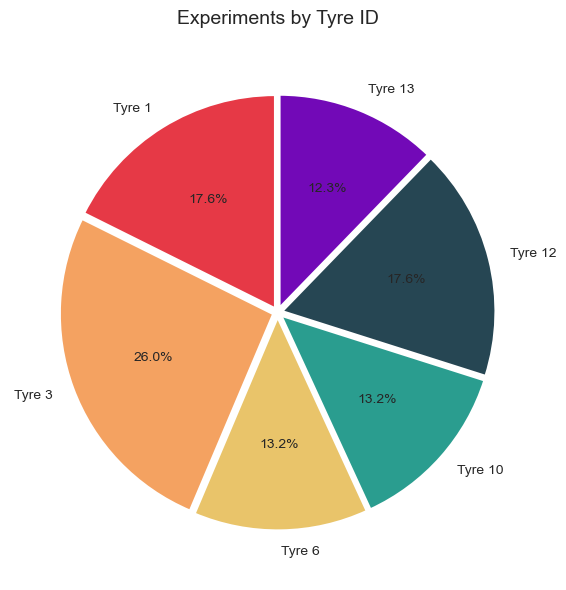

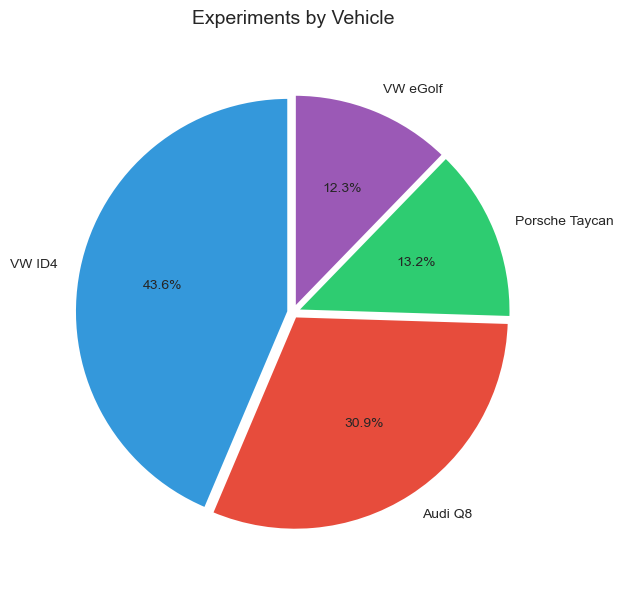

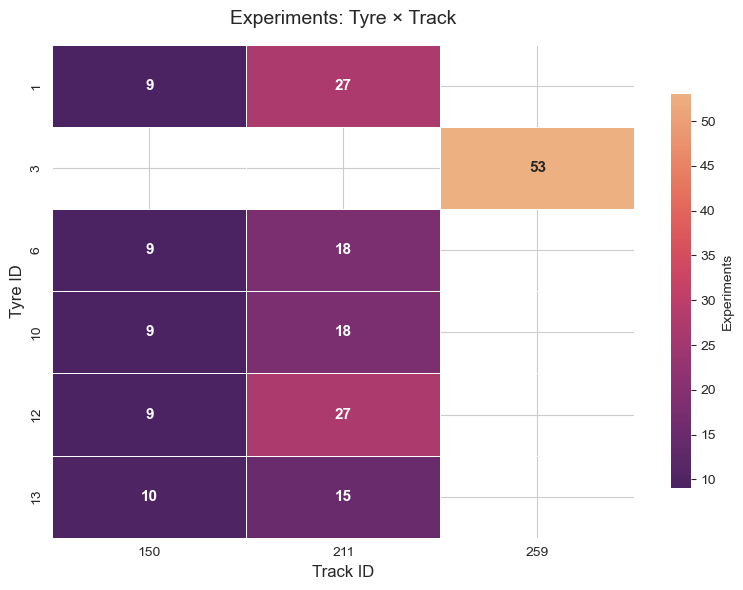

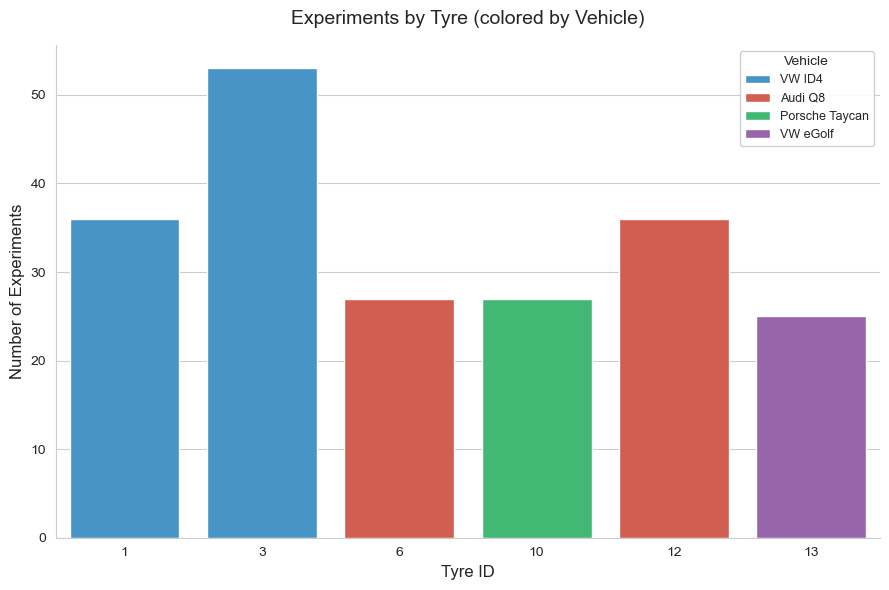

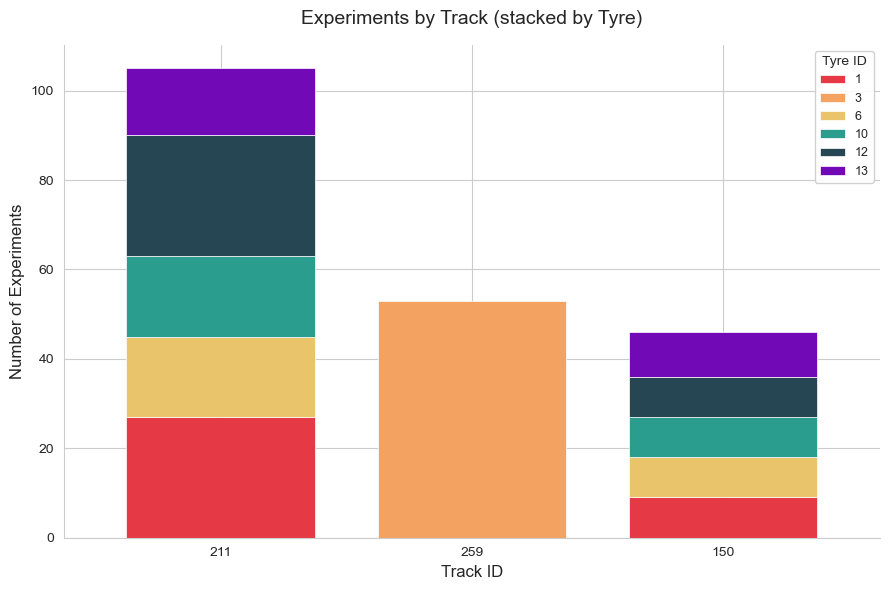

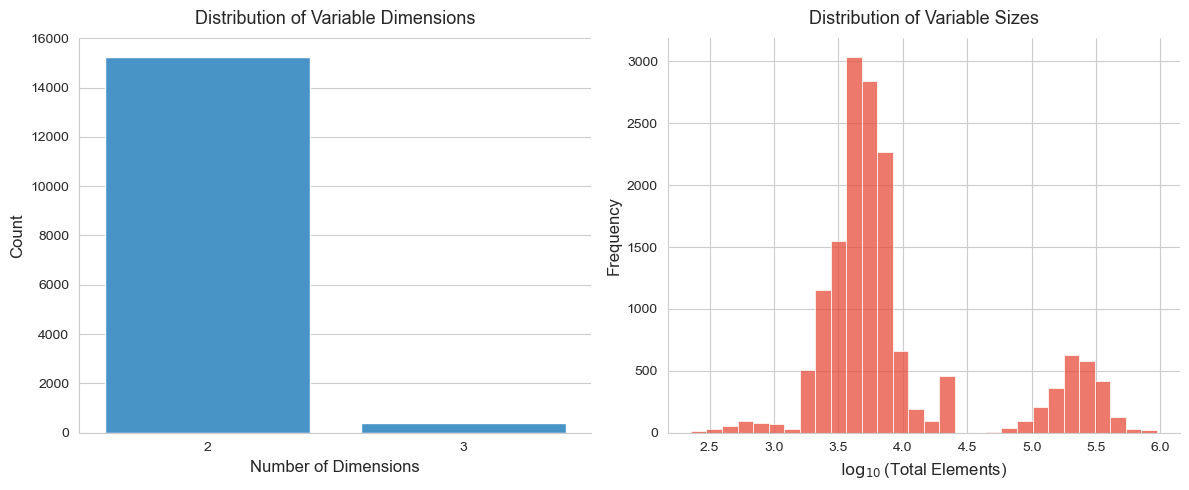

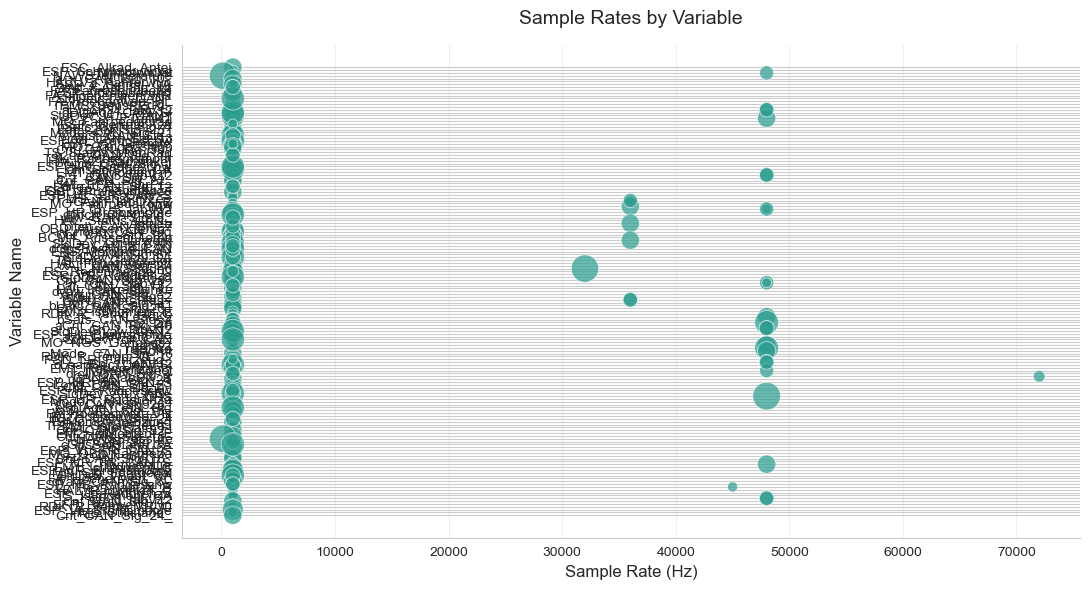

In [23]:
fig = plot_experiments_by_tyre(files_df_expanded)
fig2 = plot_experiments_by_vehicle(df=files_df_expanded)
fig3 = plot_tyre_track_heatmap(df=files_df_expanded)
fig4 = plot_experiments_by_tyre_bar(df=files_df_expanded)
fig5 = plot_experiments_by_track_bar(df=files_df_expanded)
fig6 = plot_variable_shape_dimensions(df=files_df_expanded)
fig7 = plot_sample_rate_by_variable(df=files_df_expanded)

In [18]:
# Dataset summary
print_dataset_summary(files_df_expanded)

           DATASET SUMMARY
  Total Rows:          15,659
  Unique Variables:    161
  Unique Experiments:  204

  Vehicles:  4
  Tyres:     6
  Tracks:    3

  Sample Rates:
    Min:   142 Hz
    Max:   71999 Hz
    Mean:  8201.7 Hz

  Date Range:
    From:  2025-07-11 09:39:41
    To:    2025-09-29 17:28:02


In [19]:
files_df

file_path,stem,track_ID,tyre_ID,vehicle,conventional_naming,masurement,date
str,str,i64,i64,str,bool,str,datetime[μs]
"""/Users/moritzfeik/Developer/RO…","""b35_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4""",false,"""b35_vr50""",2025-07-11 09:55:07
"""/Users/moritzfeik/Developer/RO…","""b50_ID4_RainSport5_ikaISO_2pt6…",259,3,"""01 VW ID4""",false,"""b50_vr50""",2025-07-11 10:40:06
"""/Users/moritzfeik/Developer/RO…","""b50_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4""",false,"""b50_vr50""",2025-07-11 10:03:24
"""/Users/moritzfeik/Developer/RO…","""b35_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4""",false,"""b35_vr50""",2025-07-11 09:57:46
"""/Users/moritzfeik/Developer/RO…","""ID4_RainSport5_ikaISO_3pt1_vr4…",259,3,"""01 VW ID4""",false,"""vr45""",2025-07-11 09:39:41
…,…,…,…,…,…,…,…
"""/Users/moritzfeik/Developer/RO…","""track150_Taycan_tyre10_meas3_2…",150,10,"""03 Porsche Taycan""",true,"""meas3""",2025-09-23 17:27:29
"""/Users/moritzfeik/Developer/RO…","""track150_Taycan_tyre10_meas1_2…",150,10,"""03 Porsche Taycan""",true,"""meas1""",2025-09-23 17:22:54
"""/Users/moritzfeik/Developer/RO…","""track150_Taycan_tyre10_meas3_2…",150,10,"""03 Porsche Taycan""",true,"""meas3""",2025-09-23 17:26:43


In [20]:
file2 = files_df.filter(pl.col("vehicle") == "03 Porsche Taycan")["file_path"][0]

In [21]:
def extract_h5_variables2(filename):
    """Extract variable information from an HDF5 file."""
    variables = []

    with h5py.File(filename, "r") as f:

        def collect_datasets(name, obj):
            if isinstance(obj, h5py.Dataset):
                # Get sample_rate from attributes if it exists
                sample_rate = obj.attrs.get("sample_rate", None)
                if isinstance(sample_rate, np.ndarray):
                    sample_rate = sample_rate.astype(np.int32).item()
                else:
                    sample_rate = None

                variables.append(
                    {
                        "variable_name": name,
                        "variable_shape": list(obj.shape),
                        "sample_rate": sample_rate,
                        "unit": obj.attrs.get("unit", None),
                    }
                )

        f.visititems(collect_datasets)

    return variables


extract_h5_variables2(file2)

[{'variable_name': 'CAN1_labCTRLI_',
  'variable_shape': [1, 174600],
  'sample_rate': 36000,
  'unit': Empty(dtype=dtype('O'))},
 {'variable_name': 'CAN1_labDX_B',
  'variable_shape': [1, 174600],
  'sample_rate': 36000,
  'unit': Empty(dtype=dtype('O'))},
 {'variable_name': 'Ch_1_labV12',
  'variable_shape': [1, 232800],
  'sample_rate': 48000,
  'unit': 'Pa'},
 {'variable_name': 'Ch_2_labV12',
  'variable_shape': [1, 232800],
  'sample_rate': 48000,
  'unit': 'Pa'},
 {'variable_name': 'Ch_3_labV12',
  'variable_shape': [1, 232800],
  'sample_rate': 48000,
  'unit': 'Pa'},
 {'variable_name': 'Ch_4_labV12',
  'variable_shape': [1, 232800],
  'sample_rate': 48000,
  'unit': 'Pa'},
 {'variable_name': 'Ch_5_labV12',
  'variable_shape': [1, 232800],
  'sample_rate': 48000,
  'unit': 'V'},
 {'variable_name': 'Ch_7_labV12',
  'variable_shape': [1, 232800],
  'sample_rate': 48000,
  'unit': '%'},
 {'variable_name': 'Ch_8_labV12',
  'variable_shape': [1, 232800],
  'sample_rate': 48000,
  'un